In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.sparse import hstack
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import silhouette_score
from kmodes.kmodes import KModes

In [26]:
merged_df=pd.read_csv('/content/merged_result (1).csv')

# 1. 사용할 변수만 남기기
keep_cols = ["JID_x", "SEX_TP_CD", "PAT_AGE", "CL_CD", "MAIN_SICK", "DGSBJT_CD"]
sub_sick_cols = [c for c in merged_df.columns if c.lower().startswith("sub_sick")]
keep_cols.extend(sub_sick_cols)

df = merged_df[keep_cols].copy()

# 2. 어지럼증 코드 정의
dizzy_codes = [
    "H81", "H810", "H811", "H812", "H813", "H814",
    "G440", "R42", "G45", "A881"
]

# 어지럼증 여부 판별 함수
def has_dizzy(row):
    for col in ["MAIN_SICK"] + sub_sick_cols:
        val = str(row[col])
        if any(val.startswith(code) for code in dizzy_codes):
            return True
    return False

df_dizzy = df[df.apply(has_dizzy, axis=1)].copy()
print("어지럼증 환자 수:", len(df_dizzy))

/tmp/ipython-input-1404528566.py:1: DtypeWarning: Columns (30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df=pd.read_csv('/content/merged_result (1).csv')


어지럼증 환자 수: 3458


In [27]:
# 3. 0.3% 복원추출 × 5개 샘플
samples = []
sample_size = int(len(df_dizzy) * 0.3)
for i in range(5):
    sample_df = df_dizzy.sample(n=sample_size, replace=True, random_state=42+i)
    samples.append(sample_df)

# 이제 samples[0], samples[1], ... 로 접근 가능

print(samples[0].head())

        JID_x  SEX_TP_CD  PAT_AGE  CL_CD MAIN_SICK DGSBJT_CD SUB_SICK  \
144835   3741          2       75     10      H810        13     F329   
41766    1128          2       70     10      U071         1     J060   
56393    1475          2       45     31      H819        13     M541   
51238    1357          2       65     90       R42        85      NaN   
50290    1324          2       60     10      I661         6      R42   

       SUB_SICK_1 SUB_SICK_2 SUB_SICK_3  ... SUB_SICK_32 SUB_SICK_33  \
144835       F329       R609        NaN  ...         NaN         NaN   
41766        J060       R068       K219  ...         NaN         NaN   
56393        M541       H810       R111  ...         NaN         NaN   
51238         NaN        NaN        NaN  ...         NaN         NaN   
50290         R42        R51        NaN  ...         NaN         NaN   

       SUB_SICK_34 SUB_SICK_35 SUB_SICK_36 SUB_SICK_37 SUB_SICK_38  \
144835         NaN         NaN         NaN         NaN    

In [28]:
# 2. 전부 문자열로 변환 (범주형 처리)
for col in sample_df.columns:
    sample_df[col] = sample_df[col].astype(str)

# 3. 범주형 컬럼 전부 추출
cat_cols = sample_df.columns.tolist()
print("최종 범주형 변수 개수:", len(cat_cols))


# 3. 원-핫 인코딩 (범주형 전체)
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
cat_encoded = encoder.fit_transform(sample_df.fillna("None"))

최종 범주형 변수 개수: 48


In [42]:
# --- 6. PCA ---
from sklearn.decomposition import PCA
X_dense = cat_encoded.toarray()   # PCA는 dense matrix 필요

pca = PCA(n_components=30, random_state=42)
X_pca = pca.fit_transform(X_dense)

print("설명된 분산 비율:", pca.explained_variance_ratio_)
print("누적 설명 분산:", pca.explained_variance_ratio_.cumsum())

설명된 분산 비율: [0.10619917 0.03970424 0.03505735 0.02665806 0.0221558  0.02021534
 0.01745995 0.01727417 0.01602843 0.01560282 0.01454506 0.01387656
 0.01319728 0.01277649 0.01154374 0.01126811 0.01043548 0.00993474
 0.00935632 0.0085808  0.00848101 0.00805101 0.00779519 0.00747826
 0.0072763  0.00702134 0.00670027 0.00654278 0.00627496 0.0060007 ]
누적 설명 분산: [0.10619917 0.14590341 0.18096076 0.20761881 0.22977462 0.24998995
 0.2674499  0.28472407 0.3007525  0.31635532 0.33090038 0.34477694
 0.35797422 0.37075071 0.38229444 0.39356256 0.40399803 0.41393277
 0.42328909 0.43186989 0.4403509  0.44840192 0.45619711 0.46367537
 0.47095166 0.477973   0.48467327 0.49121605 0.49749101 0.50349171]


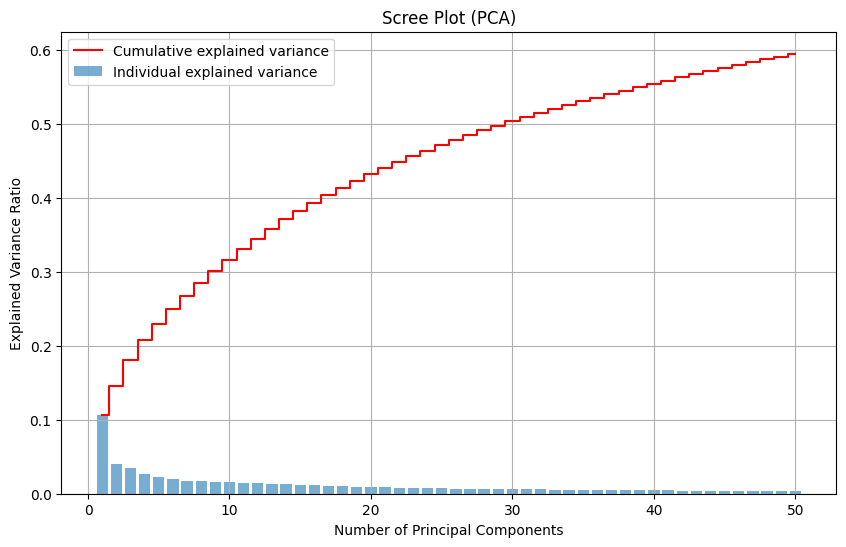

In [43]:
# PCA (예: 50차원까지)
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_dense)

# 각 주성분의 설명된 분산 비율
explained_var = pca.explained_variance_ratio_

# 누적 분산 비율
cumulative_var = explained_var.cumsum()

# --- 그래프 그리기 ---
plt.figure(figsize=(10,6))

# 개별 분산 비율 (막대그래프)
plt.bar(range(1, len(explained_var)+1), explained_var, alpha=0.6, label="Individual explained variance")

# 누적 분산 비율 (꺾은선 그래프)
plt.step(range(1, len(cumulative_var)+1), cumulative_var, where='mid', color='red', label="Cumulative explained variance")

plt.xlabel("Number of Principal Components")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot (PCA)")
plt.legend(loc="best")
plt.grid(True)
plt.show()

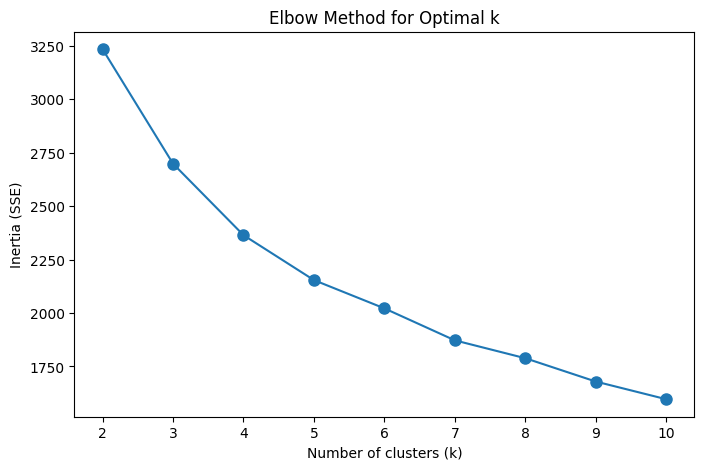

In [31]:
inertia = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'o-', markersize=8)
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (SSE)")
plt.title("Elbow Method for Optimal k")
plt.show()

In [32]:
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pca)
    sil = silhouette_score(X_pca, labels)
    print(f"k={k}, silhouette score={sil:.3f}")

k=2, silhouette score=0.307
k=3, silhouette score=0.243
k=4, silhouette score=0.194
k=5, silhouette score=0.195
k=6, silhouette score=0.195
k=7, silhouette score=0.208
k=8, silhouette score=0.207
k=9, silhouette score=0.214
k=10, silhouette score=0.215


In [33]:
# K-Modes 학습 (예: k=3)
km = KModes(n_clusters=3, init='Huang', n_init=5, random_state=42)
labels = km.fit_predict(sample_df)

sample_df["cluster_kmodes"] = labels
print(sample_df["cluster_kmodes"].value_counts())

cluster_kmodes
0    543
2    265
1    229
Name: count, dtype: int64


In [35]:
# K-Modes 학습 (예: k=4)
km = KModes(n_clusters=4, init='Huang', n_init=5, random_state=42)
labels = km.fit_predict(sample_df)

sample_df["cluster_kmodes"] = labels
print(sample_df["cluster_kmodes"].value_counts())

cluster_kmodes
1    444
0    265
2    229
3     99
Name: count, dtype: int64


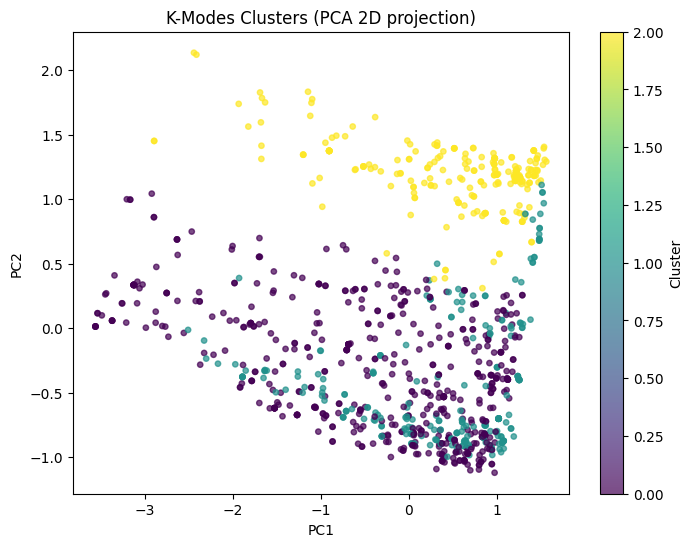

In [39]:
# 1. 범주형 원핫 인코딩 (시각화를 위해서만 필요)
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_encoded = encoder.fit_transform(sample_df)

# 2. K-Modes 클러스터링
from kmodes.kmodes import KModes
km = KModes(n_clusters=3, init='Huang', n_init=5, random_state=42)
labels = km.fit_predict(sample_df)

# 3. PCA 2차원 변환
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_encoded)

# 4. 산점도 시각화
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap="viridis", s=15, alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-Modes Clusters (PCA 2D projection)")
plt.colorbar(label="Cluster")
plt.show()

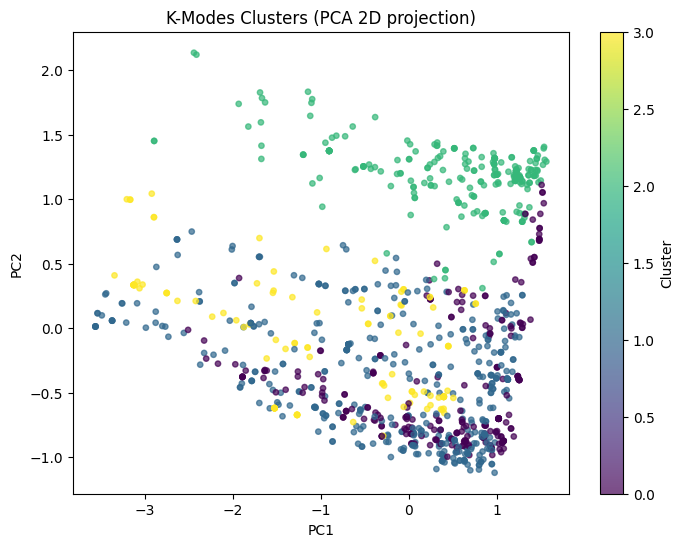

In [37]:
# 1. 범주형 원핫 인코딩 (시각화를 위해서만 필요)
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_encoded = encoder.fit_transform(sample_df)

# 2. K-Modes 클러스터링
from kmodes.kmodes import KModes
km = KModes(n_clusters=4, init='Huang', n_init=5, random_state=42)
labels = km.fit_predict(sample_df)

# 3. PCA 2차원 변환
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_encoded)

# 4. 산점도 시각화
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap="viridis", s=15, alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-Modes Clusters (PCA 2D projection)")
plt.colorbar(label="Cluster")
plt.show()

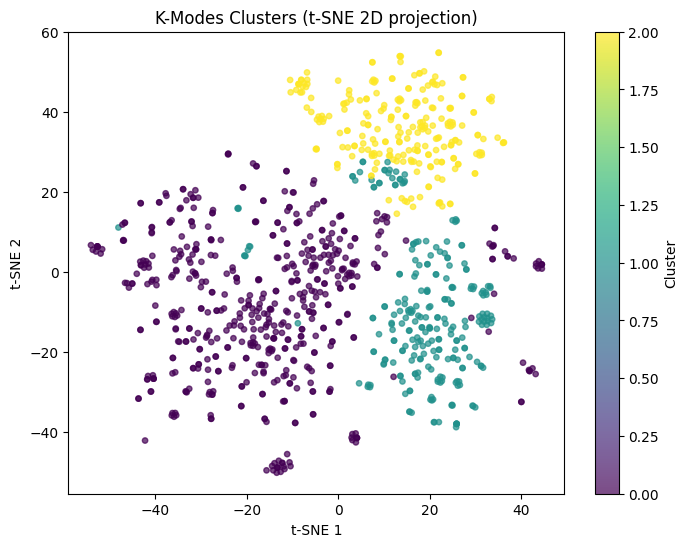

In [41]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_encoded)

plt.figure(figsize=(8,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=labels, cmap="viridis", s=15, alpha=0.7)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("K-Modes Clusters (t-SNE 2D projection)")
plt.colorbar(label="Cluster")
plt.show()